Using TF LSTM with a Sequential Model Predict a time window of a stock

#  1. Frame The Problem 
As a Stock investor i need an easier way to determing stock predictions and have better tools to assist in stock forcasting 


In [375]:
#Import the libraries
import math
import yfinance as yf
import numpy as np
import pandas as pd
from pickle import load, dump
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM # Long Short-Term Memory layer
import keras
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from timeit import default_timer as timer

plt.style.use('fivethirtyeight')

sample_start_date = (datetime.now() - timedelta(days=360)).strftime("%Y-%m-01") 
sample_stop_date = datetime.now().strftime("%Y-%m-%d") 
print("{} -> {}".format(sample_start_date, sample_stop_date))
# STOCK='CPRX'
# STOCK='AMD'
# STOCK='GME'
# STOCK='LCID'
# STOCK = 'QQQ'
# STOCK = 'AAPL'
# STOCK = 'TSLA'
STOCK = 'INTC'

n_days_to_trend=30

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(np.sqrt(-results['mean_test_score'][candidate]),
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)
        

2023-09-01 -> 2024-08-30


# 2. Get the Data 

Using an online stock store yahoo i will automatically get the data that is needed to train the model

In [376]:
#Get the stock quote 
df = yf.download(STOCK, start=sample_start_date, end=sample_stop_date)
# df = pdr.get_data_yahoo(STOCK, start=sample_start_date, end=sample_stop_date)
#Show the data 
# df
print(df)


[*********************100%***********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2023-09-01  35.790001  36.750000  35.730000  36.610001  36.007767  43782600
2023-09-05  36.580002  37.410000  36.459999  36.709999  36.106125  43379400
2023-09-06  36.560001  37.040001  36.029999  36.980000  36.371681  39643400
2023-09-07  36.830002  38.340000  36.750000  38.180000  37.551941  67659700
2023-09-08  38.119999  38.830002  37.709999  38.009998  37.384735  44255200
...               ...        ...        ...        ...        ...       ...
2024-08-23  20.320000  20.930000  20.260000  20.540001  20.540001  73398400
2024-08-26  20.530001  20.559999  19.950001  20.129999  20.129999  58534800
2024-08-27  20.129999  20.260000  19.840000  20.070000  20.070000  43862000
2024-08-28  19.980000  20.110001  19.510000  19.610001  19.610001  50144900
2024-08-29  19.760000  20.600000  19.750000  20.129999  20.129999  64529700

[250 rows x

# 3. Explore The Data 

Identify insites into what the data shows, reminbering to document any bias i might see or have 


In [377]:
df.shape

(250, 6)

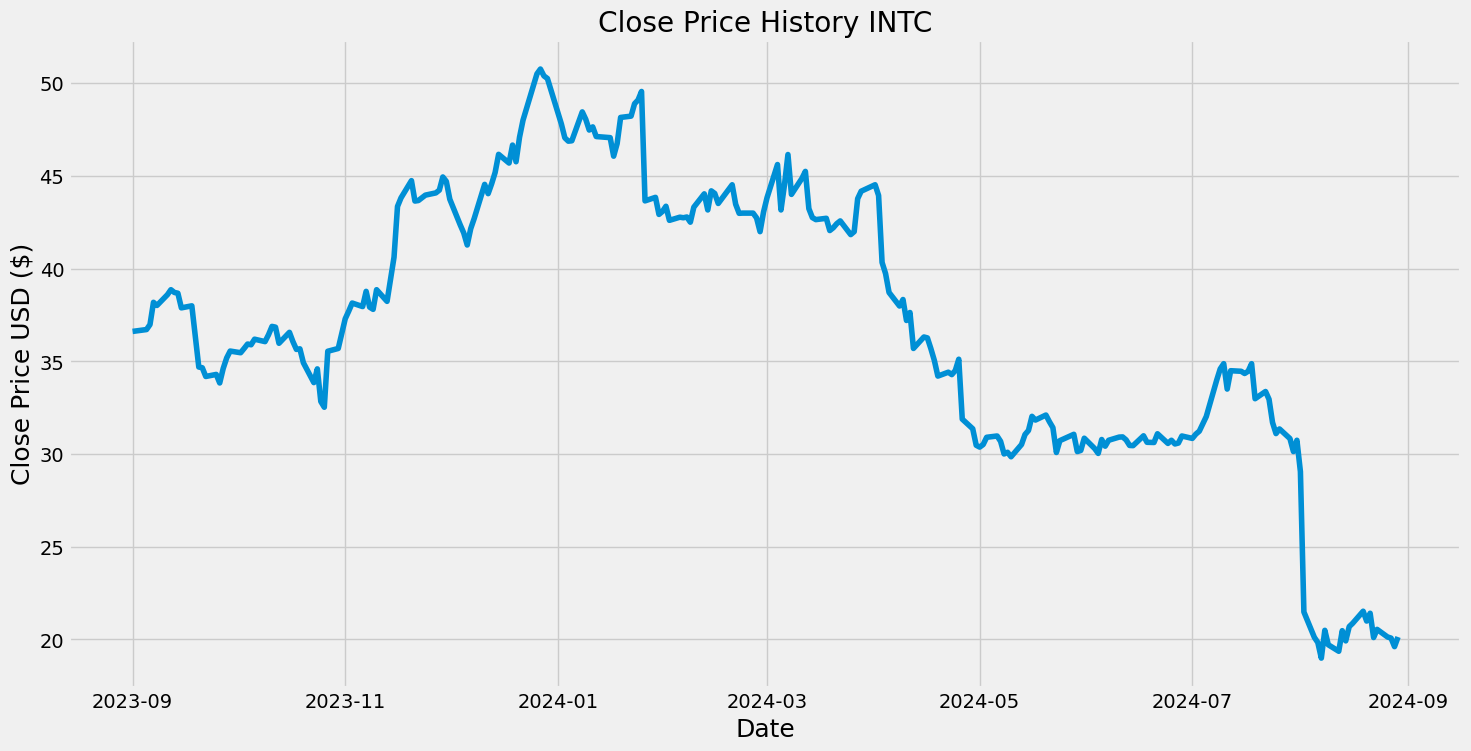

In [378]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History {}'.format(STOCK))
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [379]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
# print(data)
#Converting the dataframe to a numpy array
dataset = data.values
print(len(dataset))
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * 0.8) 

250


# 4. Prepare the Data
Using a NN it is requred to scale the data into propper bounds sets


In [380]:

#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)
# print(scaled_data)
# save the scaler
dump(scaler, open('mmscaler.pkl', 'wb'))

In [381]:
#Create the scaled training data set 
# print(training_data_len)
train_data = scaled_data[0:training_data_len, : ]
# print(len(train_data))
#Split the data into x_train and y_train data sets
x_train = []
y_train = []
for i in range(n_days_to_trend,len(train_data)):
    x_train.append(train_data[i-n_days_to_trend:i,0])
    y_train.append(train_data[i,0])
print(len(x_train))
print(len(y_train))

170
170


In [382]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [383]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# 5. Model the Data 

Using a Sequential LSTM Network apply the layers and determinig densities 


In [384]:
model = Sequential()
model.add(LSTM(units=113, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))


#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display a model summary
model.summary()

# model.save('my_stock_model.h5')

c:\Users\ethan\OneDrive\Desktop\PRSTC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 30, 113)        │        51,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 50)             │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,081 (336.25 KB)

 Trainable params: 86,081 (336.25 KB)

 Non-trainable params: 0 (0.00 B)

**Train The Model**

In [385]:
#Train the model
cb = TimingCallback()
model.fit(x_train, y_train, batch_size=1, epochs=25, callbacks=[cb])
# print(cb.logs)
print("{} Seconds".format(sum(cb.logs)))
# model.save('my_stock_model.h5')
model.save('my_stock_model.keras')

Epoch 1/25
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0524
Epoch 2/25
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0064
Epoch 3/25
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0046
Epoch 4/25
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0044
Epoch 5/25
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0037
Epoch 6/25
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0069
Epoch 7/25
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0028
Epoch 8/25
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0031
Epoch 9/25
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0028
Epoch 10/25
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0037
Epoch 11/25
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0028
Epoch 12/25
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0018
Epoch 13/25
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0021
Epoch 14/25
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0033
Epoch 15/25
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - 

In [386]:
#Test data set
test_data = scaled_data[training_data_len - n_days_to_trend: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(n_days_to_trend,len(test_data)):
    x_test.append(test_data[i-n_days_to_trend:i,0])
    

In [387]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [388]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [389]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step  


In [390]:
#Calculate/Get the value of RMSE
rmse = np.sqrt(np.mean(((predictions - y_test)**2)))
rmse

1.5930855349485653

# 6. Fine-Tune the Model 
Displaying results of predictions and adjust 

# 7. Present the soltuion 

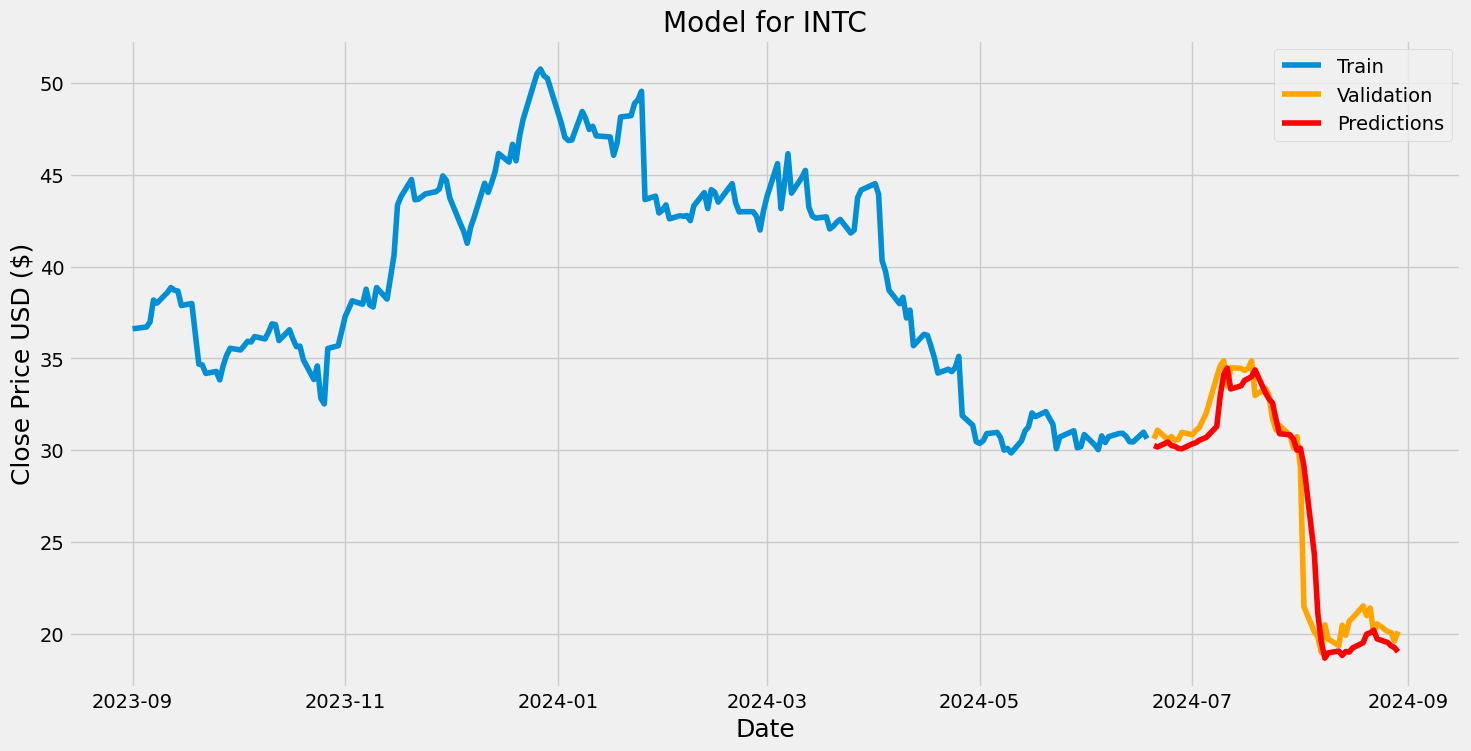

In [391]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
# print(valid['Close'])
# valid['Predictions'] = predictions
valid.insert(1, "Predictions", predictions, True) 
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model for {}'.format(STOCK))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close']], color="orange")
plt.plot(valid[['Predictions']], color='red')
plt.legend(['Train', 'Validation', 'Predictions'], loc='upper right')
# plt.show()

In [392]:
#Show the valid and predicted prices
# valid

# 8. Launch the ML System
In a true production system you would not want to load the model each time as that would be slow and would be a preformace bottleneck

In [393]:
def GetValue(High, Low, Open, Close, Volume, AdjClose):
    model = keras.models.load_model('my_stock_model.keras')
    # load the scaler
    scaler = load(open('mmscaler.pkl', 'rb'))
    # Display a model summary
#     model.summary()
    x_test = np.array([[High], [Low], [Open], [Close], [Volume], [AdjClose]])
    x_test = scaler.transform(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
    # Reshape the data into the shape accepted by the LSTM
    predictions = model.predict(x_test) 
    predictions = scaler.inverse_transform(predictions)#Undo scaling
    return predictions

# print("Predicted Value is: ", str(GetValue(66.91, 63.39, 64.46, 66.11, 83734300.0, 66.11)))
print(str(GetValue(149.48, 145.5, 146.1, 145.5, 31602100, 145.49)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
[[144.44003]
 [141.32152]
 [141.79793]
 [141.32152]
 [244.69113]
 [141.31354]]
